In [7]:
#number1
import pandas as pd
import numpy as np

# Define the file path
file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows

# Read the data into a Pandas DataFrame
df = pd.read_csv(file_path, nrows=rows)
print(df)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
10095     1     1           20  3869200268        1214         6
10096     1     1           20  3869200268        1225        10
10097     1     0           80  3869200268        1226         9
10098     1     0           53  3869200268        1313         4
10099     1     1            2  3869200268        1313        28

[10100 rows x 6 columns]


In [18]:
#NUMBER2

import pandas as pd
import numpy as np

file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows

# Read the data into a Pandas DataFrame
data = pd.read_csv(file_path, nrows=rows)

# Group by ORBIT_CNT and find the maximum BX_COUNTER value within each ORBIT_CNT
max_Obt = data.groupby('ORBIT_CNT')['BX_COUNTER'].max()
print(max_Obt)
print()

# Find the maximum value before BX_COUNTER resets to 0
V_max = max_Obt.max()

print("Maximum BX_COUNTER value before reset:", V_max)
print()

ORBIT_CNT
3869200167    3187
3869200168    3538
3869200169    2766
3869200170    3377
3869200171    3542
              ... 
3869200264    3067
3869200265    3484
3869200266    1859
3869200267    3490
3869200268    1313
Name: BX_COUNTER, Length: 102, dtype: int64

Maximum BX_COUNTER value before reset: 3563



In [34]:
#number 3
import pandas as pd
import numpy as p

# the dataframe

file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows
df = pd.read_csv(file_path, nrows=rows)
#print(df)

# Constants for time conversion
TDC_MEAS= 25/30  #  nanoseconds
BX_COUNTER =25 # nanoseconds
df['ORBIT_CNT'] = df['ORBIT_CNT'] * BX_COUNTER # to nano seconds

# adding a new column on ['HEAD'  'FPGA'  'TDC_CHANNEL'   'ORBIT_CNT'  'BX_COUNTER'  'TDC_MEAS']
df['Abs_time'] = df.loc[:,['ORBIT_CNT','BX_COUNTER', 'TDC_MEAS']].sum(axis=1)
print("The DataFrame after adding a new Column:\n", df)
print()


print("offset to make the start of data acquisition as zero")
S_time = df['Abs_time'].min()
df['A_T_ns_F_START'] = df['Abs_time'] - S_time
print()


df['Abs_time'] = pd.to_timedelta(df['A_T_ns_F_START'], unit='ns')
print(df)



The DataFrame after adding a new Column:
        HEAD  FPGA  TDC_CHANNEL    ORBIT_CNT  BX_COUNTER  TDC_MEAS     Abs_time
0         1     0          123  96730004175        2374        26  96730006575
1         1     0          124  96730004175        2374        27  96730006576
2         1     0           63  96730004175        2553        28  96730006756
3         1     0           64  96730004175        2558        19  96730006752
4         1     0           64  96730004175        2760        25  96730006960
...     ...   ...          ...          ...         ...       ...          ...
10095     1     1           20  96730006700        1214         6  96730007920
10096     1     1           20  96730006700        1225        10  96730007935
10097     1     0           80  96730006700        1226         9  96730007935
10098     1     0           53  96730006700        1313         4  96730008017
10099     1     1            2  96730006700        1313        28  96730008041

[10100 ro

In [45]:
#number4
import pandas as pd
import numpy as np
# Load the whole dataset
file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows
df = pd.read_csv(file_path, nrows=rows)


# Constants for time conversion
TDC_MEAS= 25/30  #  nanoseconds
BX_COUNTER =25 # nanoseconds
df['ORBIT_CNT'] = df['ORBIT_CNT'] * BX_COUNTER # to nano seconds

# adding a new column on ['HEAD'  'FPGA'  'TDC_CHANNEL'   'ORBIT_CNT'  'BX_COUNTER'  'TDC_MEAS']
df['Abs_time'] = df.loc[:,['ORBIT_CNT','BX_COUNTER', 'TDC_MEAS']].sum(axis=1)
print("The DataFrame after adding a new Column, results in nanoseconds:\n", df)
print()

print("offset to make the start of data acquisition as zero")
S_time = df['Abs_time'].min()
df['A_T_ns_F_START'] = df['Abs_time'] - S_time
print()

df['Abs_time'] = pd.to_timedelta(df['A_T_ns_F_START'], unit='ns')
print(df)
S_time = df['Abs_time'].min()
E_time = df['Abs_time'].max()

# Calculate the duration of data taking
D = E_time - S_time

# duration in hours, minutes, and seconds
HOURS = D.components.hours
MINUTES = D.components.minutes
SECONDS = D.components.seconds

print(f"Duration IS: {HOURS} hours, {MINUTES} minutes, {SECONDS} seconds")
print()




The DataFrame after adding a new Column, results in nanoseconds:
        HEAD  FPGA  TDC_CHANNEL    ORBIT_CNT  BX_COUNTER  TDC_MEAS     Abs_time
0         1     0          123  96730004175        2374        26  96730006575
1         1     0          124  96730004175        2374        27  96730006576
2         1     0           63  96730004175        2553        28  96730006756
3         1     0           64  96730004175        2558        19  96730006752
4         1     0           64  96730004175        2760        25  96730006960
...     ...   ...          ...          ...         ...       ...          ...
10095     1     1           20  96730006700        1214         6  96730007920
10096     1     1           20  96730006700        1225        10  96730007935
10097     1     0           80  96730006700        1226         9  96730007935
10098     1     0           53  96730006700        1313         4  96730008017
10099     1     1            2  96730006700        1313        28

In [1]:
#number 5
import pandas as pd
import numpy as np

# Load the whole dataset
file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows
df = pd.read_csv(file_path, nrows=rows)

# Group by TDC_CHANNEL and count occurrences
C_count = df.groupby('TDC_CHANNEL').size().reset_index(name='COUNT')

# Sort the channels by count in descending order
Order = C_count.sort_values(by='COUNT', ascending=False)

# Get the top 3 noisy channels and their counts
N_Channels = Order.head(3)

# Print the top 3 noisy channels and their counts
print("The top three noisy channels are:")
print(N_Channels[['TDC_CHANNEL', 'COUNT']])
print()


The top three noisy channels are:
     TDC_CHANNEL  COUNT
128          139    868
62            63    504
63            64    496



In [11]:
#NUMBER 6

import pandas as pd
import numpy as np

# Load the whole dataset
file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows
df = pd.read_csv(file_path, nrows=rows)

# Group by ORBIT_CNT and count unique orbits
Nempty_Obt = df.groupby('ORBIT_CNT')['TDC_CHANNEL'].nunique()
Num_Nempty_Obt = Nempty_Obt.count()

print("the Number of non-empty orbits is:", Num_Nempty_Obt)
print()



the Number of non-empty orbits is: 102



In [2]:
#NUMBER 7

import pandas as pd

# Load the whole dataset
file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows
df = pd.read_csv(file_path, nrows=rows)

#Filter the DataFrame for TDC_CHANNEL=139
Nunq_Obt = df[df['TDC_CHANNEL'] == 139]

#Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
Nunq_Obt_139 = Nunq_Obt['ORBIT_CNT'].nunique()

print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139:\n",Nunq_Obt_139)
#print()
#count_nempty = 0
#count_fromtdc =0
#for i in range(data['ORBIT_CNT'][0], data['ORBIT_CNT'][14999]):
 #   if i in list(zip(*data.values.tolist()))[3]:
   #     count_nempty+=1
   #     a = data.loc[(data['ORBIT_CNT'] == i) & (data['TDC_CHANNEL']==139)]
   #     if not a.empty: 
   #         count_fromtdc += 1
        
#print("Number of non-empty orbits with at least one measurement from TDC_CHANNEL=139: ",count_fromtdc)


Number of unique orbits with at least one measurement from TDC_CHANNEL=139:
 102


In [7]:
#NUMBER 8
import pandas as pd

file_path = r'C:\Users\dell\Desktop\data\data_000637.txt'
rows=10100# specify a given number of rows
df = pd.read_csv(file_path, nrows=rows)

fpga_0 = pd.Series(df[df['FPGA']==0]['TDC_CHANNEL'].value_counts()) ##selecting FPGA with number 0 and counting each instance of TDC_CHANNEL value
fpga_1 = pd.Series(df[df['FPGA']==1]['TDC_CHANNEL'].value_counts()) ##selecting FPGA with number 1 and counting each instance of TDC_CHANNEL value
print("The FPGA identified with 0:\n", fpga_0)

The FPGA identified with 0:
 TDC_CHANNEL
139    606
63     501
64     484
61     376
62     358
      ... 
106      3
97       3
101      3
98       2
99       1
Name: count, Length: 117, dtype: int64


Text(0, 0.5, 'Count')

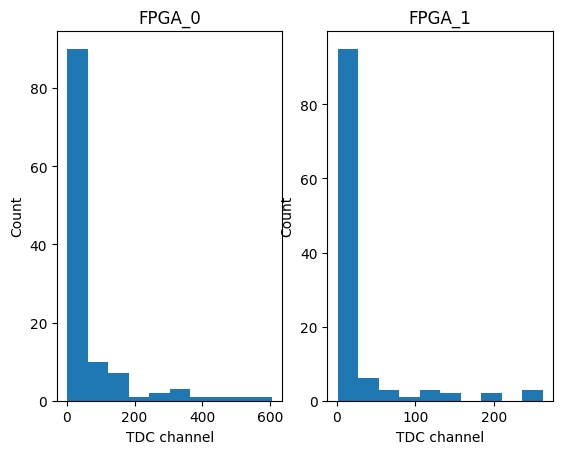

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

a = df.groupby('TDC_CHANNEL').count()['FPGA']
fig, (ax1, ax2, ) = plt.subplots(1, 2,)

ax1.hist(fpga_0) ##create histogtram
ax1.set_title('FPGA_0')
ax1.set_xlabel('TDC channel')
ax1.set_ylabel('Count')

ax2.hist(fpga_1)
ax2.set_title('FPGA_1')
ax2.set_xlabel('TDC channel')
ax2.set_ylabel('Count')